In [5]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from datasets import DatasetA, DatasetB, cfg
from datasets.base import collate_bb
import random

import random
import mlflow
import mlflow.pytorch
import subprocess
import numpy as np

from train.metrics import get_metrics
from train.plotting import plot_predictions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def make_model():
    num_classes = 25

    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)

    return model


def load_model_from_ckpt(ckpt_path, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = make_model().to(device)
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model, device

def make_test_loader_B(batch_size=1, num_workers=4):
    ds_b_test = DatasetB(cfg.root_b, "test", cfg.label_map, cfg.max_size)
    loader = DataLoader(
        ds_b_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_bb,
    )
    return ds_b_test, loader

def collect_preds_targets(model, loader, device, score_thresh=0.5, mask_thresh=0.5):
    model.eval()
    preds, targets = [], []

    for imgs, targs in loader:
        imgs = [img.to(device) for img in imgs]
        outs = model(imgs)

        for out, tgt in zip(outs, targs):
            scores = out["scores"].detach().cpu()
            keep = scores >= score_thresh

            pred = {
                "boxes": out["boxes"][keep].detach().cpu(),
                "labels": out["labels"][keep].detach().cpu(),
                "scores": scores[keep],
            }
            if "masks" in out:
                pm = (out["masks"][keep, 0] >= mask_thresh).detach().cpu().numpy().astype(np.uint8)
                pred["masks"] = pm

            gt = {
                "boxes": tgt["boxes"].detach().cpu(),
                "labels": tgt["labels"].detach().cpu(),
            }
            if "masks" in tgt:
                gm = tgt["masks"].detach().cpu().numpy().astype(np.uint8)
                gt["masks"] = gm

            preds.append(pred)
            targets.append(gt)

    return preds, targets



def ckpt_eval(ckpt_path):
    model, device = load_model_from_ckpt(ckpt_path)
    ds_b_test, test_loader = make_test_loader_B(batch_size=1, num_workers=4)

    preds, targets = collect_preds_targets(
        model, test_loader, device, score_thresh=0.5, mask_thresh=0.5
    )

    num_classes = 24
    metrics = get_metrics(preds, targets, num_classes, iou_thresh=0.5)

    print("mAP@0.5:", metrics["mAP50"])
    print("PQ_all :", metrics["PQ_all"])
    print("mPQ    :", metrics["mPQ"])
    print("AJI    :", metrics["AJI"])


    plot_predictions(ds_b_test, model, device, n=4, score_thresh=0.5)

    return metrics


/tmp/ipykernel_1114444/4052165998.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


mAP@0.5: 0.16787515580654144
PQ_all : 0.05594988280231879
mPQ    : 0.05186222465156921
AJI    : 0.35802569374599247


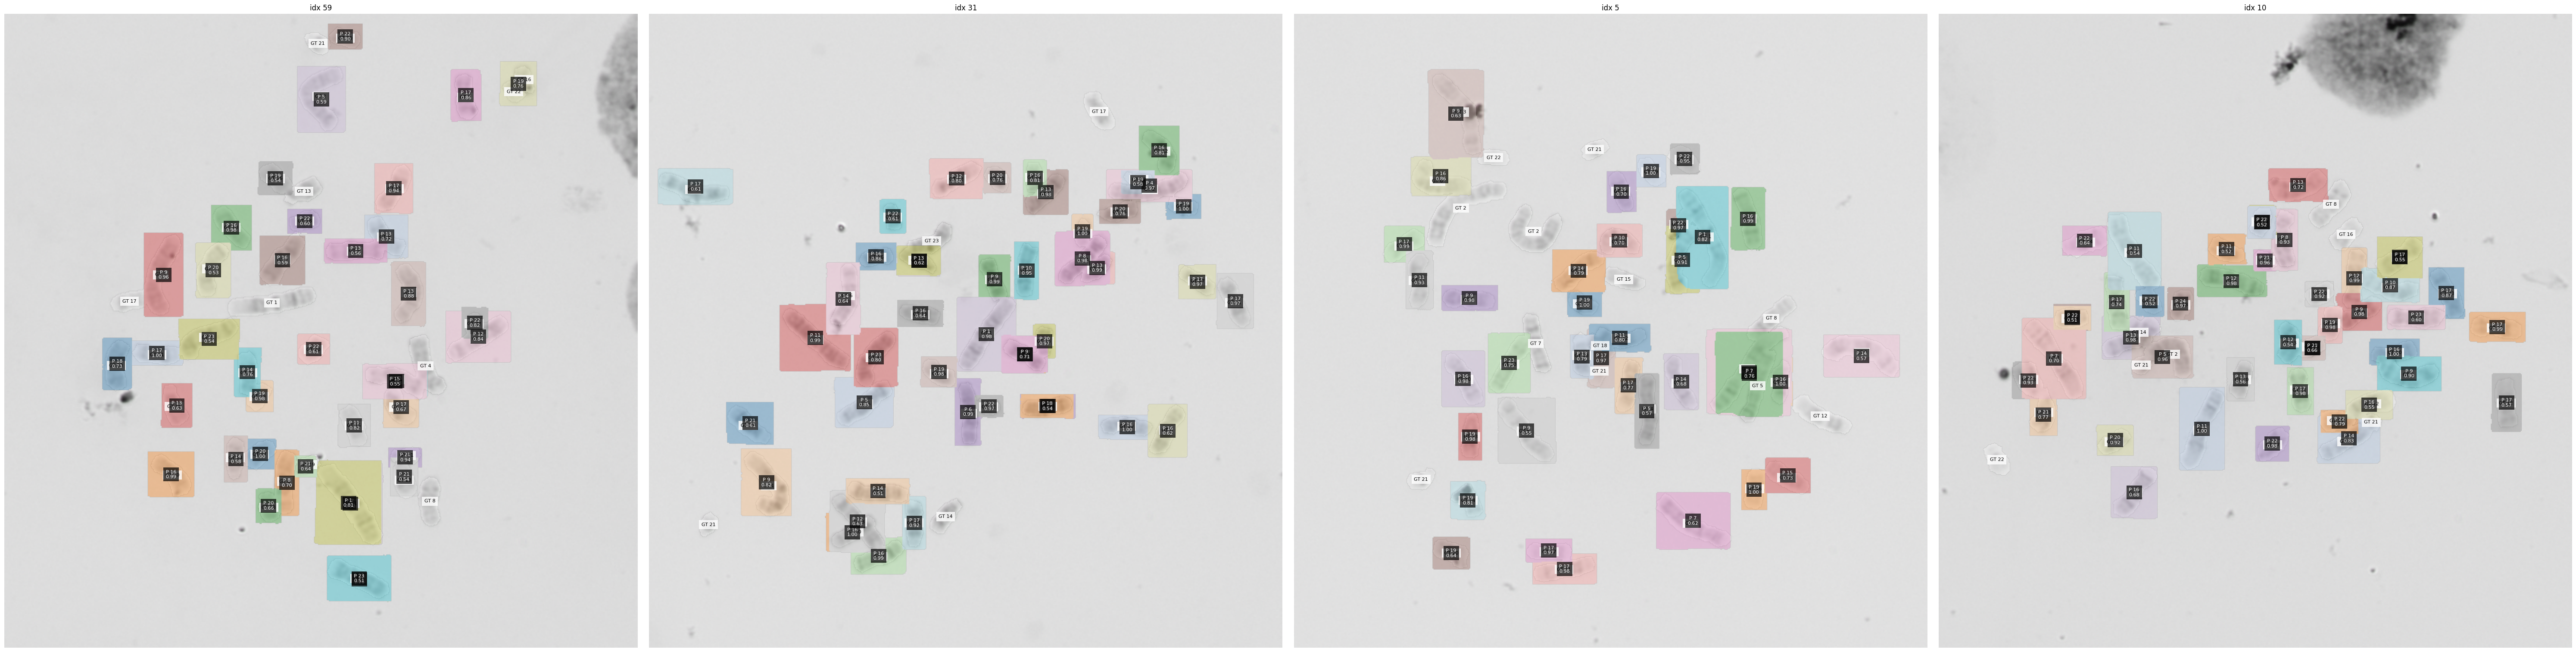

{'mAP50': 0.16787515580654144,
 'PQ_all': 0.05594988280231879,
 'mPQ': 0.05186222465156921,
 'PQ_per_class': array([0.01082481, 0.        , 0.00639501, 0.01434295, 0.05617373,
        0.0264555 , 0.01078871, 0.04015115, 0.05968753, 0.03509687,
        0.01953207, 0.03732427, 0.05707094, 0.06936435, 0.0736541 ,
        0.03022867, 0.05215284, 0.01202381, 0.14709417, 0.07394463,
        0.12714064, 0.11421288, 0.03048074, 0.14055302]),
 'AJI': 0.35802569374599247}

In [4]:
ckpt_eval("weights/maskrcnn_karyo_test.pth")